# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 


In [163]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random 
import math




In [129]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
T=1 #On considère des calls 1 an
r = 0
S = 100
sigma = 0.2

In [130]:
data

,strikes,prices
0,95,10.93
1,96,9.55
2,97,8.28
3,98,7.40
4,99,6.86
5,100,6.58
6,101,6.52
7,102,6.49
8,103,6.47
9,104,6.46


In [131]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [132]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)

In [133]:
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [134]:
black_scholes_call_price(S, 95, T, r, 0.210948)

10.930002805693796

Interpolation des volatilités implicites

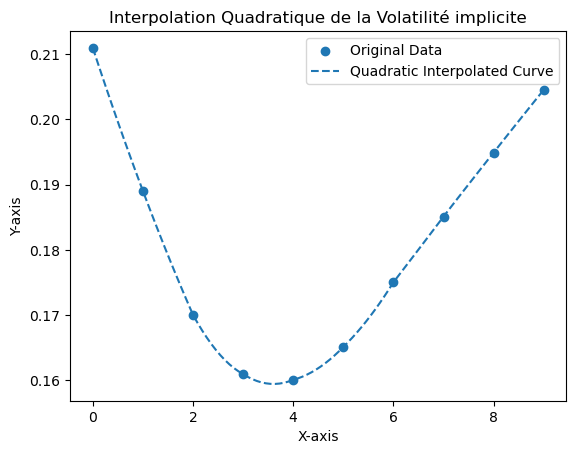

In [135]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

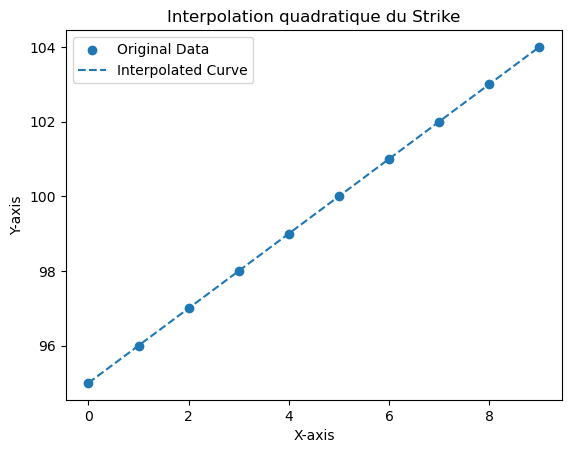

In [136]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

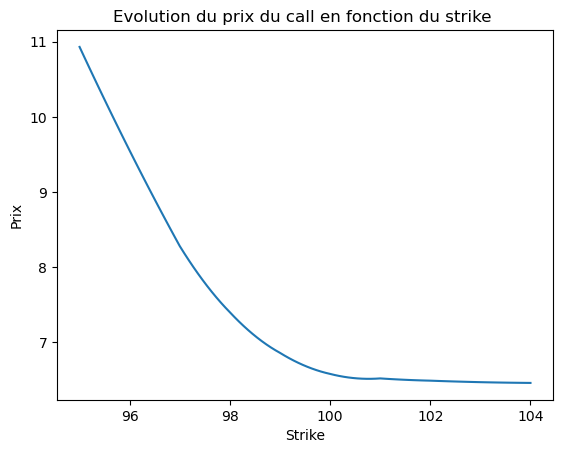

In [137]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [138]:
def neutral_risk_density(strikes , r , S , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S , T , vol_interpolated )

Afin de comparer nos deux densités, nous devons "fit" notre gaussienne 

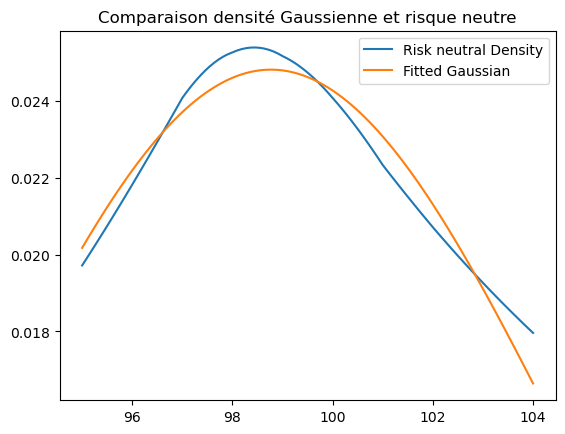

Fitted Mean: 98.7674639939289
Fitted Standard Deviation: 5.854576279872189
Fitted Amplitude (Ratio): 0.364191517778908


In [139]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, x, data):
    mu, sigma, ratio = params
    return np.sum((gaussian(x, mu, sigma, ratio) - data)**2)

initial_guess = [100, 5, 2]

result = minimize(objective, initial_guess, args=(df["Strike"], density_risque_neutre))

fitted_mu, fitted_sigma, fitted_ratio = result.x


plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

In [140]:
# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, K, T, r, pas, sigma,nb_simulations):
    dt=T/252
    paths = np.zeros((nb_simulations, pas + 1))   #on créé une matrice de taille nb_simulations x pas
    paths[:, 0] = S   #on remplit la première valeur de chaque ligne avec le spot
    
    for i in range(pas):
        paths[:, i + 1] = paths[:, i] *np.exp(dt*(r - 0.5*sigma**2) + sigma*np.sqrt(dt)* ((np.random.normal(fitted_mu,fitted_sigma,size=nb_simulations)-fitted_mu)/fitted_sigma))   #tirage dans notre loi implicite
        #pour chaque pas on calcule le prix future en utilisant le spot précédent
    option_payoffs = np.maximum(paths[:, -1] - K, 0)     #on prend ensuite le max entre notre dernier spot futur calculé - strike et 0
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  # on calcule la moyenne des payoffs qu'on actualise
    
    return option_value

In [141]:
for strike,vol,market_price in zip(data["strikes"],data["implied_vol"],data["prices"]):
    option_price_mc = valorisation_MC(S, strike, T, r, 252, vol, 10000)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}, Sigma = {vol:.2f} : {option_price_mc:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95, Sigma = 0.21 : 10.73
Market Price = 10.93, Difference = 0.20
Prix par simulation de Monte Carlo pour K = 96, Sigma = 0.19 : 9.55
Market Price = 9.55, Difference = 0.00
Prix par simulation de Monte Carlo pour K = 97, Sigma = 0.17 : 8.25
Market Price = 8.28, Difference = 0.03
Prix par simulation de Monte Carlo pour K = 98, Sigma = 0.16 : 7.46
Market Price = 7.40, Difference = 0.06
Prix par simulation de Monte Carlo pour K = 99, Sigma = 0.16 : 6.98
Market Price = 6.86, Difference = 0.12
Prix par simulation de Monte Carlo pour K = 100, Sigma = 0.17 : 6.59
Market Price = 6.58, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 101, Sigma = 0.18 : 6.60
Market Price = 6.52, Difference = 0.08
Prix par simulation de Monte Carlo pour K = 102, Sigma = 0.19 : 6.54
Market Price = 6.49, Difference = 0.05
Prix par simulation de Monte Carlo pour K = 103, Sigma = 0.19 : 6.25
Market Price = 6.47, Difference = 0.22
Prix par simulation de Monte Ca

## II – Interpolation et volatilité locale

En plus du tableau donné précédemment, on va utiliser pour cette partie les prix d’options suivants 

On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [150]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [270]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 3/12), axis=1)


df_12_months = interpolation(df_12_months,1)
df_9_months = interpolation(df_9_months,0.75)
df_6_months = interpolation(df_6_months,0.5)
df_3_months = interpolation(df_3_months,0.25)

df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated.reset_index(drop=True,inplace=True)

3/ Déterminez la nappe de volatilité correspondant à ces 40 options. 

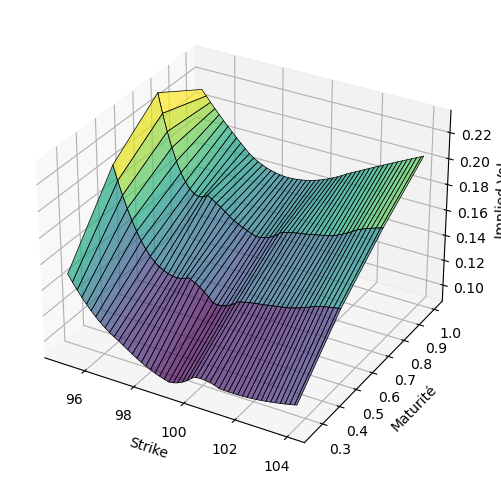

In [271]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue). 

## changer le code pour pas être cramé

In [272]:
def bilinear_interpolation(x, y, points):
    
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

On test l'interpolation bilinéaire avec une valeur que l'on connait pour estimer son erreur.<br>
Ici avec un Call K=99 T=1

In [273]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months[df_12_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months[df_12_months['strikes'] == 100]['implied_vol'].values))])

In [274]:
t1 = black_scholes_call_price(100,99,1,0,float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values))
print(f'Black Scholes Call price with implied vol from dataframe : {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'Black Scholes Call price with bilinear interpolated implied vol : {t2:.4f}')

Black Scholes Call price with implied vol from dataframe : 7.0592
Black Scholes Call price with bilinear interpolated implied vol : 6.9769


In [275]:
true_z_val = float(df_12_months[df_12_months['strikes']==100]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
error = true_z_val - z_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')
 
prix_bi = black_scholes_call_price(100,99,1,0,z_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
print(f"Prix théorique dans le dataframe: {float(df_concatenated[(df_concatenated['strikes'] == 100) & (df_concatenated['maturité'] == 1)]['prices'].values)}")

Implied vol from the dataframe : 0.1651
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0021
Prix trouvé avec l'interpolation bilinéeaire : 6.9769
Prix théorique dans le dataframe: 6.579999996457758


Les prix sont cohérents on l'utilisera donc pour calculer le call K=99.5 T=8/12

In [276]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months[df_6_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months[df_6_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )

La librairie interp2d est ici utilisée comme benchmark

In [277]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
strike_prices = list(df_concatenated[df_concatenated['maturité']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months['implied_vol'].values),
    list(df_9_months['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")

Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


In [278]:
maturities_original = [0.25, 0.5, 0.75, 1]  # en mois
strikes_original = list(df_concatenated['strikes'])
implied_vol_original = list(df_concatenated['implied_vol'])
 
# Les valeurs à interpoler
maturity_interpolated = 8/12  # en mois
strike_interpolated = 99.50
 
# Appel de la fonction d'interpolation quadratique
x_interpolated = [maturity_interpolated]
x_original = maturities_original
y_original = implied_vol_original
 
y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
# Afficher le résultat
print(f"Le prix interpolé pour une option avec strike {strike_interpolated} et maturité {maturity_interpolated:.4f} année est : {y_interpolated[0]:.4f}")

Le prix interpolé pour une option avec strike 99.5 et maturité 0.6667 année est : 0.2074


In [279]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
error = implied_volatility_8_12[0] - z_995_val
print(f'The error between bilinear interpolation and true value is : {error:.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le dataframe: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : -0.0075
Prix trouvé avec l'interpolation quadratique : 6.9850
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique dans le dataframe: 4.7066


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes : 
- écrire l’algorithme de valorisation d’une option avec le modèle SVI(stochastic volatility inspired), par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres ; 


##### voir slide 69 la formule pour le modèle SVI

In [280]:
# Fonction SVI (slide 69 du cours)
def svi(param, x):
    a, b, rho, m, sigma = param
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))

# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, param,r, nb_simulations, pas, strike, maturity):
    dt=T/252
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0] = S   
    for i in range(pas):
        vol = svi(param, paths[:, i])   #A chaque pas on calcule notre volatilité avec le modèle SVI
        paths[:, i + 1] = paths[:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)   
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)  #payoff actualisé

    return option_value

On teste la valorisation des options 12 mois et comparons à nos vraies valeurs de marché.
Pour le set de paramètres nous utilisons celui déterminé dans la suite du projet, qui minimise l'erreur moyenne.

In [281]:
# Paramètres du modèle SVI 
calibrated_params = [ 1.31037559e-01,  1.84852425e-02 ,-3.89813515e-01,  9.77848385e+01 ,1.65244084e+00]

# Valorisation de l'option par Monte Carlo
for strike,price in zip(data["strikes"],data["prices"]):
    option_value_mc = valorisation_MC(S, calibrated_params,r, 10000, 252, strike, 1)
    print(f"Prix par simulation de Monte Carlo pour K = {strike} : {option_value_mc:.2f}")
    print(f"Market Price = {price:.2f}, Difference = {abs(option_value_mc-price):.2f}")

Prix par simulation de Monte Carlo pour K = 95 : 10.21
Market Price = 10.93, Difference = 0.72
Prix par simulation de Monte Carlo pour K = 96 : 8.99
Market Price = 9.55, Difference = 0.56
Prix par simulation de Monte Carlo pour K = 97 : 9.06
Market Price = 8.28, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 98 : 8.33
Market Price = 7.40, Difference = 0.93
Prix par simulation de Monte Carlo pour K = 99 : 7.94
Market Price = 6.86, Difference = 1.08
Prix par simulation de Monte Carlo pour K = 100 : 7.05
Market Price = 6.58, Difference = 0.47
Prix par simulation de Monte Carlo pour K = 101 : 7.17
Market Price = 6.52, Difference = 0.65
Prix par simulation de Monte Carlo pour K = 102 : 6.43
Market Price = 6.49, Difference = 0.06
Prix par simulation de Monte Carlo pour K = 103 : 6.13
Market Price = 6.47, Difference = 0.34
Prix par simulation de Monte Carlo pour K = 104 : 5.70
Market Price = 6.46, Difference = 0.76


Notre algorithme de valorisation par Monte Carlo nous donne des prix proches

- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


In [282]:
def svi(param, x):
    a, b, rho, m, sigma = param
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))

# Fonction de coût à minimiser
def cost_function(param, strikes, vols_market):
    vols_model = [svi(param, x) for x in strikes]
    return np.sum((vols_model - vols_market) ** 2)

# Données de marché
strikes_12m = df_12_months["strikes"]
vols_market_12m = df_12_months["implied_vol"]
strikes_9m = df_9_months["strikes"]
vols_market_9m = df_9_months["implied_vol"]
strikes_6m = df_6_months["strikes"]
vols_market_6m = df_6_months["implied_vol"]
strikes_3m = df_12_months["strikes"]
vols_market_3m = df_3_months["implied_vol"]

# Initialisation des paramètres
initial_params = [0.1, 0.1, -0.5, 100, 0.1]

# Minimisation de la fonction de coût
result_12m = minimize(cost_function, initial_params, args=(strikes_12m, vols_market_12m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_9m = minimize(cost_function, initial_params, args=(strikes_9m, vols_market_9m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_6m = minimize(cost_function, initial_params, args=(strikes_6m, vols_market_6m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory
result_3m = minimize(cost_function, initial_params, args=(strikes_3m, vols_market_3m), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory

# Paramètres calibrés
calibrated_params_12m = result_12m.x
calibrated_params_9m = result_9m.x
calibrated_params_6m = result_6m.x
calibrated_params_3m = result_3m.x

# Affichage des résultats
print("Paramètres calibrés 12m:", calibrated_params_12m)
print("Paramètres calibrés 9m:", calibrated_params_9m)
print("Paramètres calibrés 6m:", calibrated_params_6m)
print("Paramètres calibrés 3m:", calibrated_params_3m)

Paramètres calibrés 12m: [ 1.50915432e-01  1.33252989e-02 -3.28606287e-01  9.81899908e+01
  3.49539451e-01]
Paramètres calibrés 9m: [ 1.85838966e-02  9.22258500e-01 -9.87432925e-01  9.32027814e+01
  8.88190244e-01]
Paramètres calibrés 6m: [ 2.44778313e-02  3.24054906e-01 -9.71729439e-01  9.35904296e+01
  1.32014956e+00]
Paramètres calibrés 3m: [ 9.11947925e-02  1.00407466e-02 -8.16805967e-01  9.79483089e+01
  4.75968204e-01]


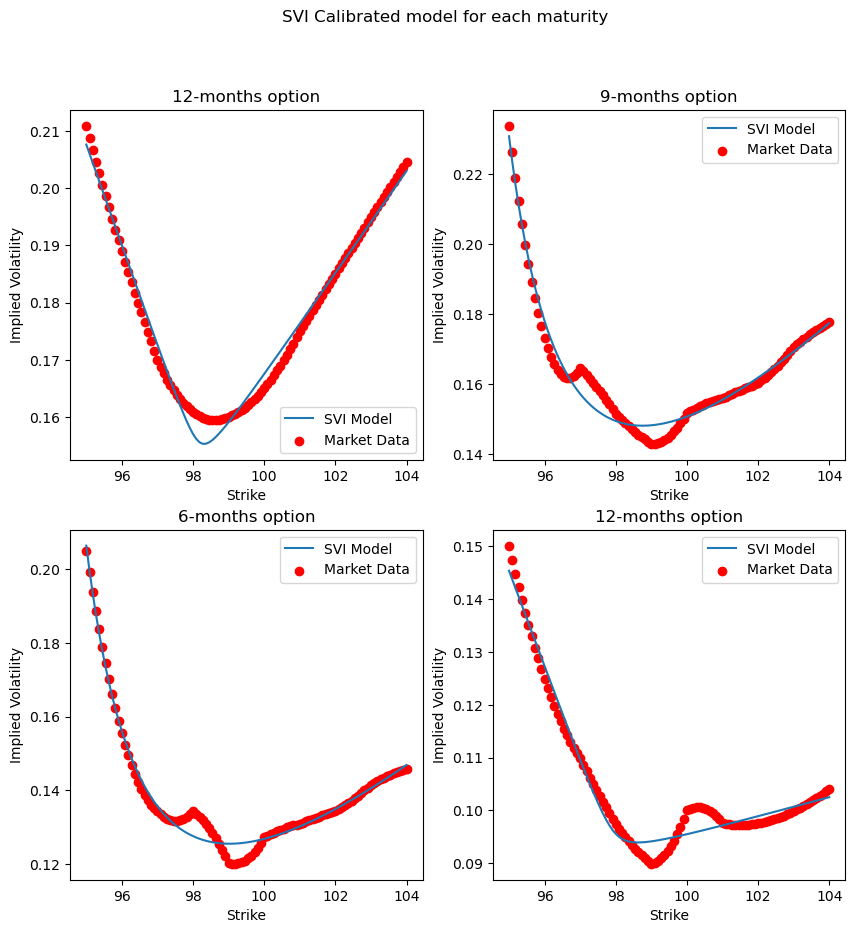

In [283]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(min(strikes_12m), max(strikes_12m), 100)
vols_plot = [svi(calibrated_params_12m, x) for x in strikes_plot]

ax1.plot(strikes_plot, vols_plot, label='SVI Model')
ax1.scatter(strikes_12m, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

strikes_plot = np.linspace(min(strikes_9m), max(strikes_9m), 100)
vols_plot = [svi(calibrated_params_9m, x) for x in strikes_plot]

ax2.plot(strikes_plot, vols_plot, label='SVI Model')
ax2.scatter(strikes_9m, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

strikes_plot = np.linspace(min(strikes_6m), max(strikes_6m), 100)
vols_plot = [svi(calibrated_params_6m, x) for x in strikes_plot]

ax3.plot(strikes_plot, vols_plot, label='SVI Model')
ax3.scatter(strikes_6m, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

strikes_plot = np.linspace(min(strikes_3m), max(strikes_3m), 100)
vols_plot = [svi(calibrated_params_3m, x) for x in strikes_plot]

ax4.plot(strikes_plot, vols_plot, label='SVI Model')
ax4.scatter(strikes_3m, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("12-months option")
ax4.legend()

plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 

In [284]:
calibrated_params_concat = [calibrated_params_12m]+[calibrated_params_9m]+[calibrated_params_6m]+[calibrated_params_3m]

In [285]:
def svi_fixed(param, calibrated_params, x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))
 
# Liste des options et des prix du marché
strikes = df_concatenated["strikes"]
maturity = df_concatenated['maturité']
market_prices = df_concatenated["prices"]
vol_market= df_concatenated["implied_vol"]
 
# Fonction d'erreur pour l'optimisation
def cost_function(param, calibrated_params, strike, vol_market):
    vols_model = svi_fixed(param, calibrated_params, strike)
    return (vols_model - vol_market) ** 2

# Estimation des paramètres a et b pour chaque option
a_values = []
b_values = []
i = 0
for k, sigma in zip(strikes, vol_market):
    if k == 104.0 and i < 3:
        i += 1
    res = minimize(cost_function, [0.1, 0.1], args=(calibrated_params_concat[i], k, sigma))
    a, b = res.x
    a_values.append(a)
    b_values.append(b)

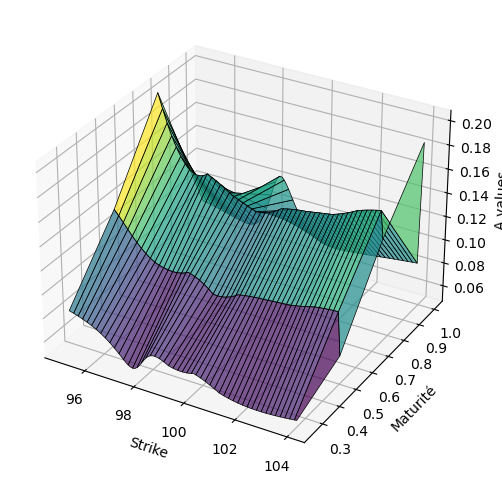

In [286]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface pour créer une surface 3D
ax.plot_surface(np.array(strikes).reshape(4,-1), 
                np.array(maturity).reshape(4,-1),
                np.array(a_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('A values')

# Affichage de la figure
plt.show()

A voir si on utilise les valeurs interpolées

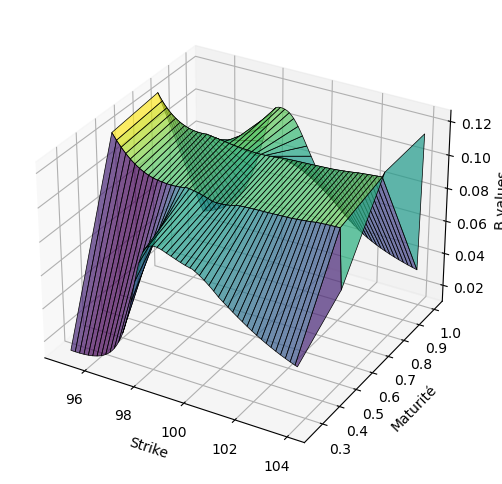

In [287]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.array(strikes).reshape(4,-1), 
                np.array(maturity).reshape(4,-1),
                np.array(b_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)
# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('B values')

# Affichage de la figure
plt.show()

5/ En utilisant les nappes obtenues pour le modèle SVI (à la dernière étape), proposer encore un prix, 
le plus juste possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode 
retenue). 

In [288]:
df_concatenated['a_values'] = a_values
df_concatenated['b_values'] = b_values

Brouillon explication : 

interpolation de a values pour 99.5/8M interpolation de b values pour 99.5/8M

imp vol svi = svi (param [a_inter,b_inter,calibrated param])

BS(K,t,imp vol svi)


TEST DU MODEL DE BILINEARITE

In [295]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values))
                                        ]                 
                               )
z2_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values))
                                        ]                 
                               )

On teste l'interpolation pour les a et b values du modèle svi, avec des données que l'on connait déjà pour voir si le modèle nous sort des prix cohérents 

In [290]:
test_imp = svi([z_val,z2_val,calibrated_params_concat[0][2],calibrated_params_concat[0][3],calibrated_params_concat[0][4]],99)
price = black_scholes_call_price(100,99,1,0,test_imp)
price

6.860000099009902

Vrai prix

In [291]:
float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['prices'].values)

6.859999997306801

Voir diff entre true value et model value

In [292]:
x_val = 99.5
y_val = 8/12
a_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 100)]['a_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 100)]['a_values'].values))
                                        ]                 
                               )
b_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturité'] == 0.75) & (df_concatenated['strikes'] == 100)]['b_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturité'] == 1) & (df_concatenated['strikes'] == 100)]['b_values'].values))
                                        ]                 
                               )

In [308]:
calibrated_params_concat

[array([ 1.50915432e-01,  1.33252989e-02, -3.28606287e-01,  9.81899908e+01,
         3.49539451e-01]),
 array([ 1.85838966e-02,  9.22258500e-01, -9.87432925e-01,  9.32027814e+01,
         8.88190244e-01]),
 array([ 2.44778313e-02,  3.24054906e-01, -9.71729439e-01,  9.35904296e+01,
         1.32014956e+00]),
 array([ 9.11947925e-02,  1.00407466e-02, -8.16805967e-01,  9.79483089e+01,
         4.75968204e-01])]

In [307]:
def linear_interpolation(x0, y0, x1, y1, x):
    slope = (y1 - y0) / (x1 - x0)
    y = y0 + slope * (x - x0)
    return y

In [311]:
rho_8m = linear_interpolation(6,calibrated_params_concat[2][2],9,calibrated_params_concat[1][2],8)
m_8m = linear_interpolation(6,calibrated_params_concat[2][3],9,calibrated_params_concat[1][3],8)
sigma_8m = linear_interpolation(6,calibrated_params_concat[2][4],9,calibrated_params_concat[1][4],8)

voir si on douille le prof avec les paramètres du 3 mois plutot que le 9 mois

In [322]:
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_concat[3],99.5) #Calibrated param for 6 months

In [318]:
imp_vol_svi_8_inter = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],99.5) #Calibrated param for 6 months

In [323]:
price_svi = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8)
print(f"Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : {price_svi:.4f}")
price_svi_inter = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8_inter)
print(f"Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : {price_svi_inter:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le calculé par interp2d: {prix_interp2d:.4f}")

Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : 4.6455
Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : 4.1704
Prix théorique dans le calculé par interp2d: 4.7066


Justifier notre méthode choisie